In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install catboost

## Загрузка данных (2 балла)

Загрузим наши файлы в train и test

In [3]:
train = pd.read_csv('../input/advanced-dls-spring-2021/train.csv')

In [4]:
test = pd.read_csv('../input/advanced-dls-spring-2021/test.csv')

Выведем случайные 5 строк

In [5]:
train.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
577,10,102.10,1068.85,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),1
1161,43,29.30,1224.05,Male,0,Yes,Yes,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),0
5167,3,86.85,220.95,Female,1,No,No,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,1
897,53,71.85,3827.9,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,No,Yes,No,Yes,Month-to-month,No,Electronic check,0
2279,47,94.90,4615.25,Female,0,No,No,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,No,One year,No,Credit card (automatic),0


In [6]:
train.shape

(5282, 20)

Наш дата сет состоит из <strong>5282 фичей и 20 признаков <br>
Churn - целевая переменная</strong>

Вынесем целевую переменную в отдельную и удалим ее из фрейма

In [7]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [8]:
train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Мы видим, что в наших данных <strong>нет пропусков</strong>. <br>
Однако <strong>TotalSpent имеет тип object</strong>, когда явно должен иметь float <br>
Рассмотрим содержание этого признака

In [10]:
train['TotalSpent'].value_counts()

           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

Мы видим(первая строчка), что у нас есть <strong>9 пробелов</strong> в этом столбце<br>
Выведем фичи с пробелами

In [11]:
train[train['TotalSpent']==' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Мы также видим, что эти столбцы имеют <strong>0 в столбце CliendPeriod</strong>, чего быть не должно<br>
Проверим сколько всего фичей, где CliendPeriod = 0

In [12]:
train[train['ClientPeriod'] == 0].shape

(9, 20)

Всего таких значений 9 и это как раз те 9 фичей, которые мы нашли выше<br>
Проверим нашу теорию:

In [13]:
train[train.TotalSpent == ' '].index == train[train['ClientPeriod'] == 0].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

Возращаемый массив заполнен True -> наша теория верна

Заполним пробелы нулями

In [14]:
train.replace(' ', 0, inplace=True)

Приведем признак к типу float

In [15]:
train['TotalSpent'] = train['TotalSpent'].astype(float)

Проверим есть ли пробелы в тестовой выборке

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [17]:
test[test.TotalSpent == ' '].index

Int64Index([177, 767], dtype='int64')

Также заполним их нулями и приведем к типу float

In [18]:
test.replace(' ', 0, inplace=True)
test['TotalSpent'] = test['TotalSpent'].astype(float)

Посмотрим сколько уникальных значений в каждом признаке

In [19]:
train.nunique()

ClientPeriod                  73
MonthlySpending             1468
TotalSpent                  4978
Sex                            2
IsSeniorCitizen                2
HasPartner                     2
HasChild                       2
HasPhoneService                2
HasMultiplePhoneNumbers        3
HasInternetService             3
HasOnlineSecurityService       3
HasOnlineBackup                3
HasDeviceProtection            3
HasTechSupportAccess           3
HasOnlineTV                    3
HasMovieSubscription           3
HasContractPhone               3
IsBillingPaperless             2
PaymentMethod                  4
Churn                          2
dtype: int64

## Анализ данных (3 балла)

1) Построим гистограмму для численных признаков
разобьем нашу целевую переменную на "ушел"(1) и "остался"

In [20]:
gone_1 = train[train[target_col] == 1]
stay_0 = train[train[target_col] == 0]

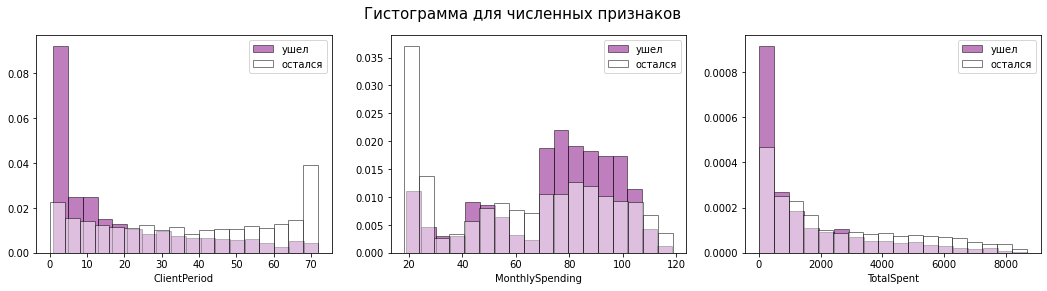

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
fig.suptitle('Гистограмма для численных признаков', fontsize=15)
for i, num_col in enumerate(num_cols):
    axes[i].hist(x=gone_1[num_col], bins=18, density=True, alpha=0.5, label='ушел', edgecolor='black', color='purple')
    axes[i].hist(x=stay_0[num_col], bins=18, density=True, alpha=0.5, label='остался', edgecolor='black', color='white')
    axes[i].set(xlabel = num_col) #подписать столбцы(признаки) у каждого графика
    axes[i].legend()


Теперь посмотрим на категориальные и биноминальное распределение признаков

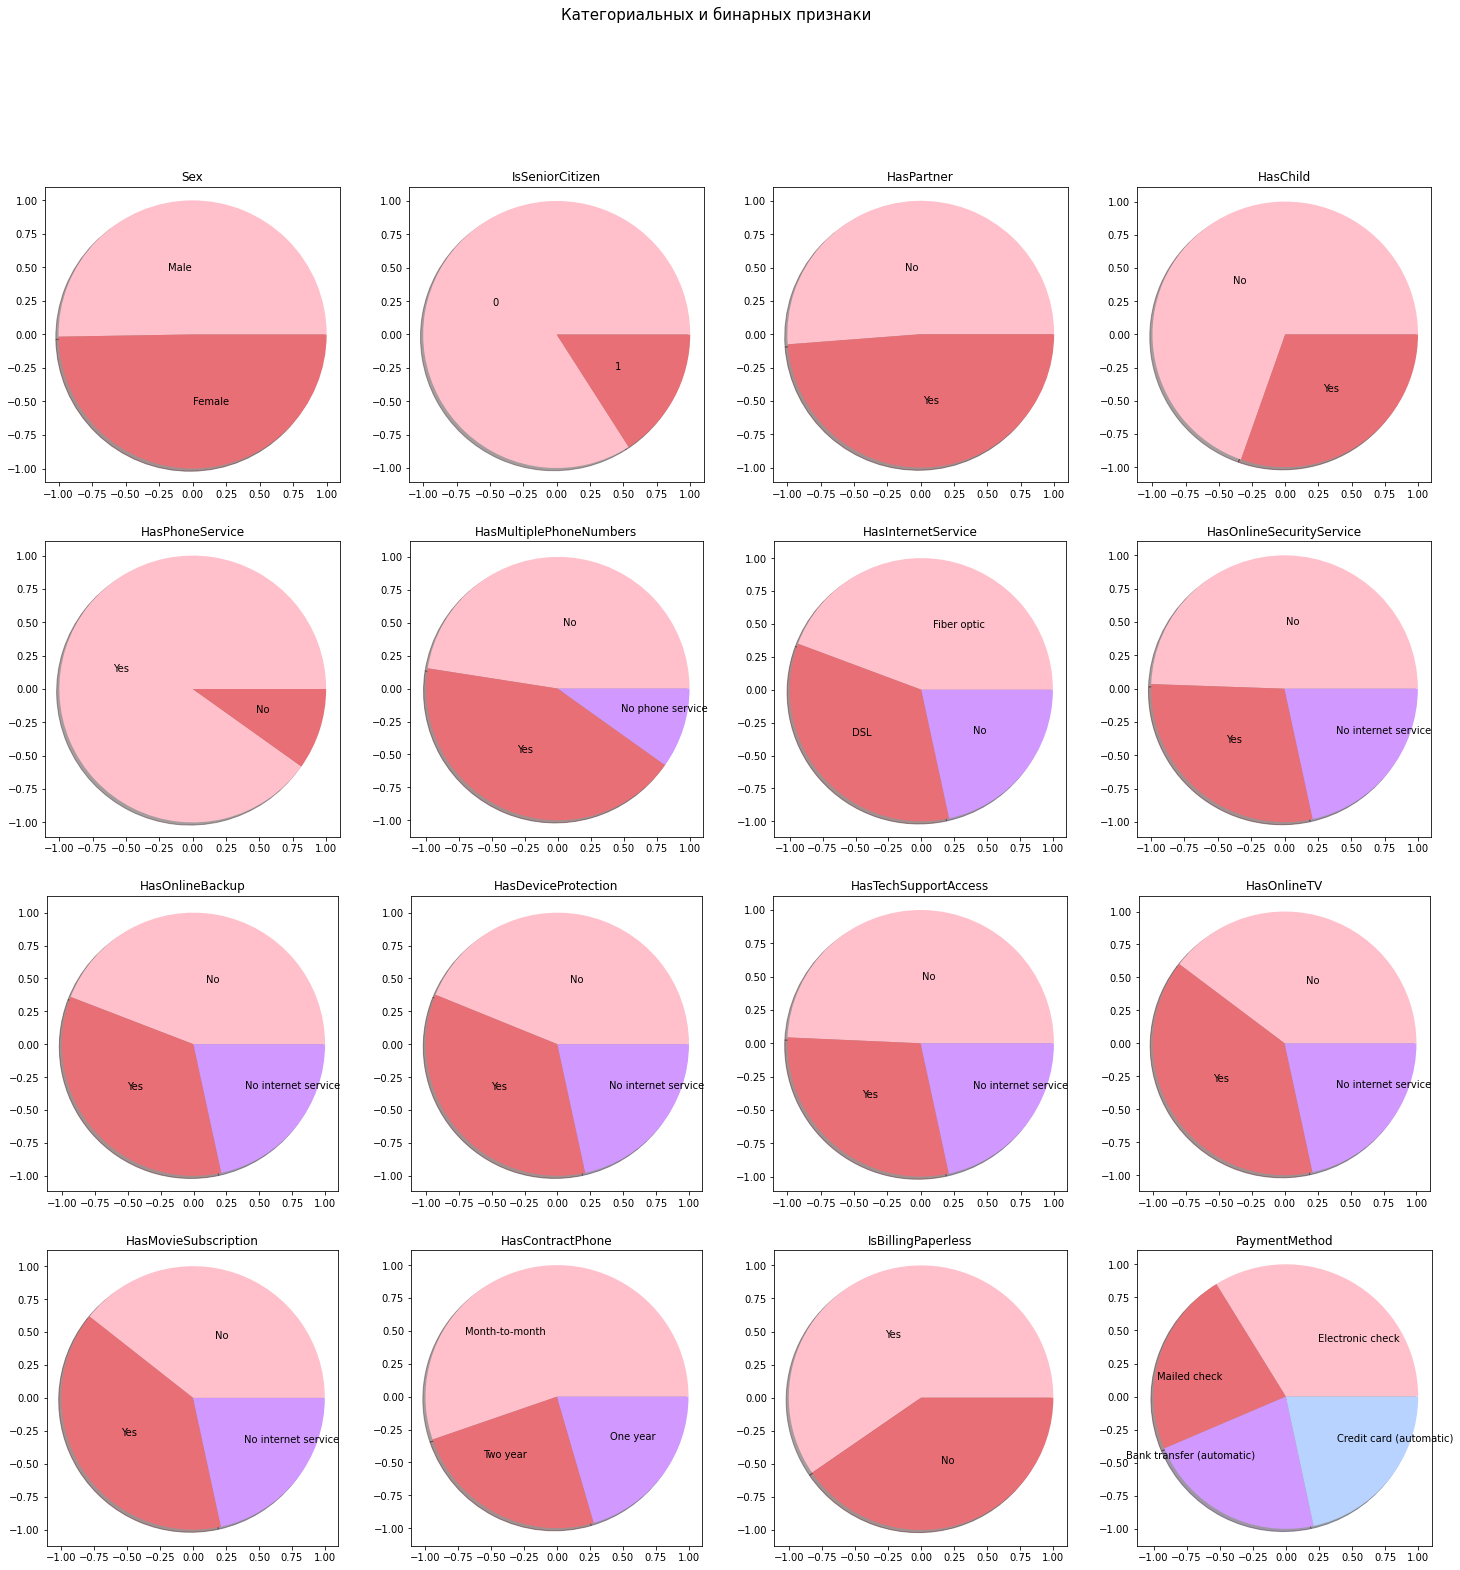

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 25))
ax = axes.ravel()
fig.suptitle('Категориальных и бинарных признаки', fontsize=15)
for i, cat in enumerate(cat_cols):
    x = train[cat].value_counts() #признаки
    index = x.index #наименования в признаках
    ax[i].pie(frame=True, x=x, labels=index, colors=['pink', '#e86f75', '#d199ff', '#b8d3ff'], labeldistance = 0.5,shadow=True)
    ax[i].set_title(cat)

Расмотрим распеределение классов целевой переменной:

In [23]:
train[target_col].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

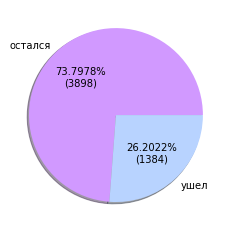

In [24]:
def count_pr(x):
    return '{:.4f}%\n({:.0f})'.format(x, total*x/100)

v_counts = train[target_col].value_counts()
total = len(train[target_col])
plt.pie(v_counts, labels=["остался", "ушел"], autopct=count_pr, colors=['#d199ff', '#b8d3ff'], shadow=True);

Вывод: классы не являются сбалансированными -> В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

## Применение линейных моделей (3 балла)

In [25]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [27]:
#создадим копии непредобработанных данных для catboost
y_train = train[target_col]
X_train = train.drop(target_col, axis=1)

### **Логистическая регрессия**

Перейдем к предобработке данных<br>
Для численных значений используем StandardScaler<br>
Категориальные разобьем с помощью OneHotEncoder

In [28]:
prepare_data = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(), cat_cols)
    ])

Создадим экземпляр модели с помощью pipeline<br>
Подбор параметров и кросс-валидацию проведем в GridSearchCV()

In [29]:
do_pipeline = Pipeline([
        ("preparation", prepare_data),
        ("linear", LogisticRegression(solver = 'liblinear', random_state=42))
    ])

In [30]:
param_grid = [
        {'linear__penalty':['l1', 'l2'],
         'linear__C':[120, 100, 10, 1, 0.1, 0.01, 0.001]
         }
    ]

grid_search1 = GridSearchCV(do_pipeline, param_grid, scoring='roc_auc', verbose=2, refit=True, n_jobs=-1)

In [31]:
logreg = grid_search1.fit(train[feature_cols], train[target_col])

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [32]:
print("Лучшие параметры: ")
logreg.best_params_

Лучшие параметры: 


{'linear__C': 120, 'linear__penalty': 'l1'}

In [33]:
print("Его скор: ")
logreg.best_score_

Его скор: 


0.8451287829199179

#### <strong>Теперь обчим на elasticnet</strong>

In [34]:
do_pipeline2 = Pipeline([
        ("preparation", prepare_data),
        ("linear", LogisticRegression(solver = 'saga', random_state=42, l1_ratio=1))
    ])

C2 = [120, 100]
param_grid2 = [
        {'linear__penalty': ['elasticnet'],
         'linear__C': C2
         }
    ]

grid_search2 = GridSearchCV(do_pipeline2, param_grid2, scoring='roc_auc',  refit=True, n_jobs=-1)

In [35]:
logreg2 = grid_search2.fit(train[feature_cols], train[target_col])
print('Обучение модели elasticnet завершено')

Обучение модели elasticnet завершено


In [36]:
print("Лучшие параметры: ")
logreg2.best_params_

Лучшие параметры: 


{'linear__C': 120, 'linear__penalty': 'elasticnet'}

In [37]:
print("Его скор: ")
logreg2.best_score_

Его скор: 


0.8451269522609521

In [38]:
print("Лучшие параметры линейной модели:")
if logreg.best_score_ > logreg2.best_score_:
    print(logreg.best_params_)
    print("скор: ", logreg.best_score_)
else:
    print(logreg2.best_params_)
    print("скор: ", logreg2.best_score_)

Лучшие параметры линейной модели:
{'linear__C': 120, 'linear__penalty': 'l1'}
скор:  0.8451287829199179


Линейная модель дала неплохой скор, но нужно попробовать и другие модели

### **KNN**

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline([
        ("preparation", prepare_data),
        ("model", KNeighborsClassifier())
    ])

knn_param_grid = [
        {'model__n_neighbors': [44], # range(1, 50)
         'model__weights':['uniform'], #'uniform', 'distance'
         'model__metric': ['manhattan', 'braycurtis'],
        }]

grid_search3 = GridSearchCV(knn_pipeline, knn_param_grid, scoring='roc_auc', refit=True, n_jobs=-1)

In [40]:
knn = grid_search3.fit(train[feature_cols], train[target_col])

In [41]:
print("Лучшие параметры: ")
knn.best_params_

Лучшие параметры: 


{'model__metric': 'braycurtis',
 'model__n_neighbors': 44,
 'model__weights': 'uniform'}

In [42]:
print("Его скор: ")
knn.best_score_

Его скор: 


0.8333476760547661

### **GaussianNB**

In [43]:
from sklearn.naive_bayes import GaussianNB

In [44]:
nb_pipeline = Pipeline([
        ("preparation", prepare_data),
        ("model", GaussianNB())
    ])

nb_param_grid = [
        {'model__var_smoothing': [1e-7], #1e-7, 1e-8, 1e-9, 1e-10
        }]

grid_search4 = GridSearchCV(nb_pipeline, nb_param_grid, scoring='roc_auc', refit=True, n_jobs=-1)

In [45]:
nb = grid_search4.fit(train[feature_cols], train[target_col])

In [46]:
print("Лучшие параметры: ")
nb.best_params_

Лучшие параметры: 


{'model__var_smoothing': 1e-07}

In [47]:
print("Его скор: ")
nb.best_score_

Его скор: 


0.8184093884745647

### **Random Forest**

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
rf_pipeline = Pipeline([
        ("preparation", prepare_data),
        ("model", RandomForestClassifier(random_state=42))
    ])

rf_param_grid = [
        {'model__n_estimators': [100], #100, 200, 300
         'model__max_depth': [10], #2, 4, 5, 10, 15, 20, 30
         'model__max_features': [10], #2,3,5,10, 15, 20, 30
         'model__min_samples_leaf': [18], #range(1, 50)
        }]

grid_search5 = GridSearchCV(rf_pipeline, rf_param_grid, scoring='roc_auc', refit=True, n_jobs=-1)

In [50]:
rf = grid_search5.fit(train[feature_cols], train[target_col])

In [51]:
print("Лучшие параметры: ")
rf.best_params_

Лучшие параметры: 


{'model__max_depth': 10,
 'model__max_features': 10,
 'model__min_samples_leaf': 18,
 'model__n_estimators': 100}

In [52]:
print("Его скор: ")
rf.best_score_

Его скор: 


0.8451854765817359

## Применение градиентного бустинга (2 балла)

In [53]:
from catboost import CatBoostClassifier, Pool

P.S. Ни один котик не пострадал

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_train.values, y_train.values, train_size=0.8, random_state=42)

In [56]:
catboost_train_dataset = Pool(data=X_train_cb,
                  label=y_train_cb,
                  cat_features=cat_cols,
                  feature_names=feature_cols
                  )

In [57]:
cv_classifer = CatBoostClassifier(loss_function = 'Logloss',
                                    random_state = 42,
                                    eval_metric = 'AUC:hints=skip_train~false', #метрика, используемая для обнаружения переобучения
                                    bootstrap_type = 'Bayesian', # метод сэмплинга весов объектов
                                    verbose = False,
                                    early_stopping_rounds = 300,
                                    )
grid = {"iterations": [100, 200, 300, 500], #30, 50, 100, 200, 300, 500
        "learning_rate":[0.03, 0.05], #0.03, 0.05, 0.1, 0.2, 0.3, 0.5
        "max_depth": [4], #2,4,6,8
        "grow_policy":['Lossguide'],#как будет применяться жадный алгоритм поиска
        "min_data_in_leaf":[100], #30, 50, 100, 150, 200
        "score_function": ['L2'],} #тип оценки, используемой для выбора следующего разбиения

cb_grid_search = cv_classifer.grid_search(grid, X=catboost_train_dataset, cv=5, refit=True)


bestTest = 0.8384122671
bestIteration = 75

0:	loss: 0.8384123	best: 0.8384123 (0)	total: 841ms	remaining: 5.89s

bestTest = 0.839300092
bestIteration = 86

1:	loss: 0.8393001	best: 0.8393001 (1)	total: 1.45s	remaining: 4.36s

bestTest = 0.8394151139
bestIteration = 192

2:	loss: 0.8394151	best: 0.8394151 (2)	total: 2.92s	remaining: 4.88s

bestTest = 0.8403245054
bestIteration = 199

3:	loss: 0.8403245	best: 0.8403245 (3)	total: 4.21s	remaining: 4.21s

bestTest = 0.8398176904
bestIteration = 299

4:	loss: 0.8398177	best: 0.8403245 (3)	total: 6.15s	remaining: 3.69s

bestTest = 0.8405006326
bestIteration = 286

5:	loss: 0.8405006	best: 0.8405006 (5)	total: 8.04s	remaining: 2.68s

bestTest = 0.840694732
bestIteration = 457

6:	loss: 0.8406947	best: 0.8406947 (6)	total: 11.3s	remaining: 1.62s

bestTest = 0.8405006326
bestIteration = 286

7:	loss: 0.8405006	best: 0.8406947 (6)	total: 14.2s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 0.8642043486
bestIterat

In [58]:
cb_grid_search['params']

{'min_data_in_leaf': 100,
 'depth': 4,
 'iterations': 500,
 'learning_rate': 0.03,
 'grow_policy': 'Lossguide',
 'score_function': 'L2'}

In [59]:
y_train_predicted = cv_classifer.predict_proba(X_train)[:, 1]
train_searching_auc = roc_auc_score(y_train, y_train_predicted)
train_searching_auc

0.874555593204756

Функция потерь LogLoss:<br>
Лучший скор: 0.874555593204756<br>
Лучшие параметры: {'min_data_in_leaf': 100,<br>
 'iterations': 100,<br>
 'learning_rate': 0.3,<br>
 'grow_policy': 'Depthwise'}<br>

In [60]:
patterns = {
    "No": 0,
    "No internet service": 0,
    "No phone service": 0,
    "Yes": 1,
    "Male": 0,
    "Female": 1,
    "DSL": 1,
    "Fiber optic": 2,
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2,
    "Credit card (automatic)": 0,
    "Bank transfer (automatic)": 1,
    "Mailed check": 2,
    "Electronic check": 3,
}
X_train = train.replace(patterns).drop(target_col, axis=1)
y_train = train[target_col]
X_test = test[feature_cols].replace(patterns)

In [61]:
from sklearn.ensemble import StackingClassifier

meta = CatBoostClassifier(
    verbose = False,
    eval_metric="AUC:hints=skip_train~false",
    random_seed=42,
    grow_policy="Lossguide",
    bootstrap_type = 'Bayesian',
    learning_rate=0.05,
    max_depth=8,
    min_data_in_leaf=80,
)
stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("knn", knn),
        ("nb", nb),
        ("rf", rf),
        ("catboost", cv_classifer),
    ],
    final_estimator=meta,
    n_jobs=-1,
)

stacking.fit(X_train, y_train)

[CV] END ..................linear__C=120, linear__penalty=l1; total time=   1.2s
[CV] END ..................linear__C=120, linear__penalty=l2; total time=   0.1s
[CV] END ..................linear__C=100, linear__penalty=l1; total time=   1.0s
[CV] END ..................linear__C=100, linear__penalty=l1; total time=   1.2s
[CV] END ...................linear__C=10, linear__penalty=l1; total time=   1.0s
[CV] END ....................linear__C=1, linear__penalty=l1; total time=   0.3s
[CV] END ....................linear__C=1, linear__penalty=l1; total time=   0.2s
[CV] END ....................linear__C=1, linear__penalty=l2; total time=   0.1s
[CV] END ....................linear__C=1, linear__penalty=l2; total time=   0.1s
[CV] END ..................linear__C=0.1, linear__penalty=l1; total time=   0.2s
[CV] END ..................linear__C=0.1, linear__penalty=l2; total time=   0.1s
[CV] END ..................linear__C=0.1, linear__penalty=l2; total time=   0.1s
[CV] END .................li

StackingClassifier(estimators=[('logreg',
                                GridSearchCV(estimator=Pipeline(steps=[('preparation',
                                                                        ColumnTransformer(transformers=[('num',
                                                                                                         StandardScaler(),
                                                                                                         ['ClientPeriod',
                                                                                                          'MonthlySpending',
                                                                                                          'TotalSpent']),
                                                                                                        ('cat',
                                                                                                         OneHotEncoder(),
                                 

In [62]:
#y_test_predicted = stacking.predict_proba(X_test)[:, 1]

### **Скор стекинга:**

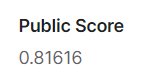

In [63]:
y_test_predicted = cv_classifer.predict_proba(test)[:, 1]

### **Скор catboost:**

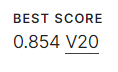

In [64]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

curve = get_roc_curve(cv_classifer, catboost_train_dataset)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

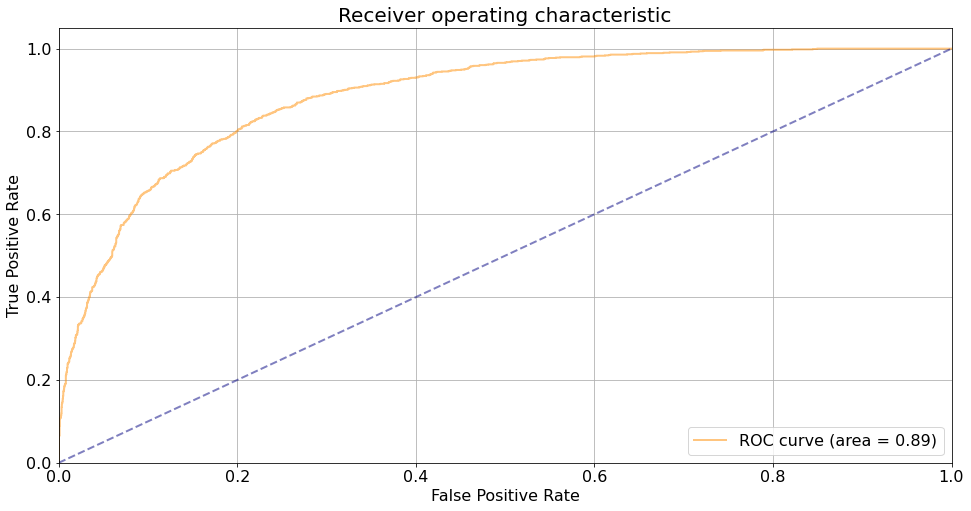

In [65]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [66]:
submission = pd.read_csv('../input/advanced-dls-spring-2021/submission.csv')
submission['Churn'] = y_test_predicted

In [67]:
submission.head()

,Id,Churn
0,0,0.046640
1,1,0.757409
2,2,0.681704
3,3,0.023818
4,4,0.008853


In [68]:
submission.to_csv('/kaggle/working/submission.csv', index = False)